# GP Sampling

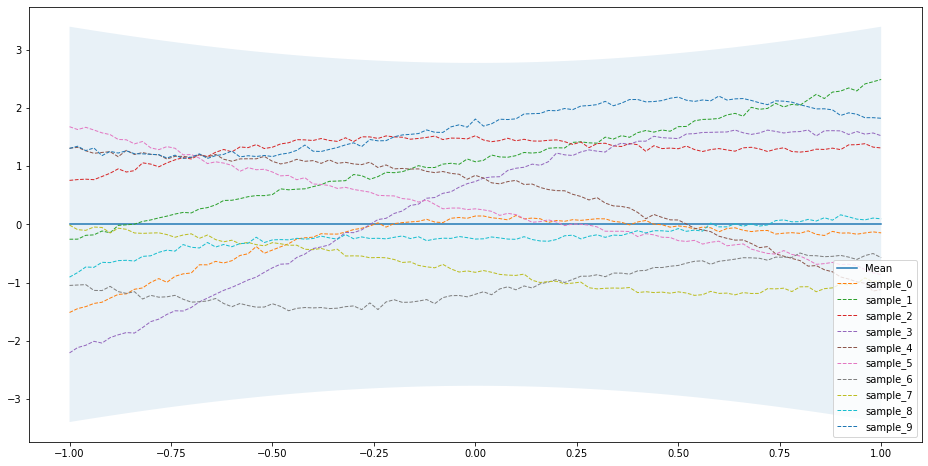

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def gaussian_rbf(x1, x2, theta1):
    # distance between each rows
    dist_matrix = np.sum(np.square(x1), axis=1).reshape(-1, 1) + np.sum(np.square(x2), axis=1) - 2 * np.dot(x1, x2.T)
    return np.exp(-theta1/2* dist_matrix)

    
def k_func(x, theta0, theta1, theta2, theta3):
    n = len(x)
    x_ = x.reshape(-1, 1)
    rbf = gaussian_rbf(x_, x_,theta1) # n, 1

    outer_matrix = np.dot(x_,x.reshape(1,-1))
    
    return theta0 * rbf + theta2 + theta3 * outer_matrix

def GP_cov(x, beta_inv, k_func, theta0, theta1, theta2, theta3):
    n = len(x)
    K = k_func(x, theta0, theta1, theta2, theta3)
    cov = beta_inv * np.eye(n) + K
    return cov

def plot_gp(mu, cov, X, samples=[]):
    X = X.reshape(-1)
    mu = mu.reshape(-1)

    # 95% confidence interval
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    plt.figure(figsize=(16,8))
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')

    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label='sample_{}'.format(i))

    plt.legend()

x = np.arange(-1, 1.02, 0.02)
cov = GP_cov(x, 0.001, k_func, 1, 1, 1, 1)

# t = np.random.multivariate_normal(np.zeros(len(x)), cov)

mu = np.zeros(len(x))
samples = np.random.multivariate_normal(mu.reshape(-1), cov, 10)
plot_gp(mu, cov, x, samples)

# GP Regression

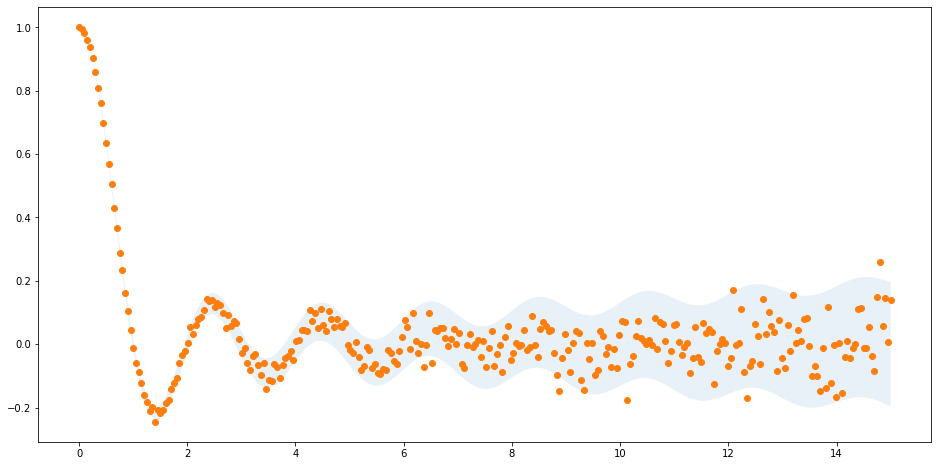

In [4]:


def dim1_make_data(func=np.sinc, start=0., end=15., nums=300, sigma_start=0.001, sigma_end=0.1):

    x = np.linspace(start, end, nums)
    y = func(x)
    sigmas = np.linspace(sigma_start, sigma_end, nums)
    t = y + sigmas * np.random.normal(0, 1, nums)
    return x, y, t, sigmas

x, y, t, sigmas = dim1_make_data()
uncertainty = 1.96 * sigmas
plt.figure(figsize=(16,8))
plt.fill_between(x, y + uncertainty, y - uncertainty, alpha=0.1)
plt.scatter(x, t)
plt.show()


In [12]:
import copy

def gaussian_rbf(x1, x2, theta1):
    # distance between each rows
    dist_matrix = np.sum(np.square(x1), axis=1).reshape(-1, 1) + np.sum(np.square(x2), axis=1) - 2 * np.dot(x1, x2.T)
    return np.exp(-theta1/2* dist_matrix)

    
def k_func(x1, x2, theta0, theta1, theta2, theta3):

    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    rbf = gaussian_rbf(x1, x2,theta1) # n, 1

    outer_matrix = np.dot(x1,x2.reshape(1,-1))
    
    return theta0 * rbf + theta2 + theta3 * outer_matrix

def GP_cov(x, beta_inv, k_func, theta0, theta1, theta2, theta3):
    n = len(x)
    K = k_func(x, x, theta0, theta1, theta2, theta3)
    cov = beta_inv * np.eye(n) + K
    return cov


class GPR: # 넘파이 코드
    def __init__(self, beta_inv, k_func, theta0, theta1, theta2, theta3):
        self.beta_inv = beta_inv
        self.k_func = k_func
        self.theta0 = theta0
        self.theta1 = theta1
        self.theta2 = theta2
        self.theta3 = theta3
        self.cov_train = None
        self.train_x = None
        self.train_t = None

    def fit(self, x, t):
        self.train_x = x
        self.train_t = t
        self.cov_train = GP_cov(x, self.beta_inv, self.k_func, self.theta0, self.theta1, self.theta2, self.theta3)

    def get_inference_K_col(self, x_test):
        return self.k_func(self.train_x, x_test, self.theta0, self.theta1, self.theta2, self.theta3)
    
    def expand_cov(self, K, c):
        N = self.cov_train.shape[0]
        new_cov = np.zeros((N+1, N+1))
        new_cov[:N, :N] = self.cov_train
        for i in range(N):
            new_cov[i, N] = K[i][0]
            new_cov[N, i] = K[i][0]
        new_cov[N][N] = c

        self.cov_train = copy.deepcopy(new_cov)

    def test(self, x_tests): # x_test는 단일 값.
        mus = []
        covs = []
        for x_test in x_tests: # iterative 말고 한번에 해도 되지 않을까? 일단 이런식으로 돌아간다는 것만 숙지.
            K_test = self.get_inference_K_col(x_test)
            matrix = np.dot(K_test.T, np.linalg.inv(self.cov_train)) # 1, N @ N, N
            mu = np.dot(matrix, self.train_t)
            c = self.beta_inv + self.k_func(x_test, x_test, self.theta0, self.theta1, self.theta2, self.theta3)
            cov = c - np.dot(matrix, K_test)
            covs.append(cov)
            mus.append(mu)
            self.expand_cov(K_test, c)
            self.train_x = np.concatenate([self.train_x, [x_test]], axis=0)
            self.train_t = np.concatenate([self.train_t, mu], axis=0)
        return mus, covs


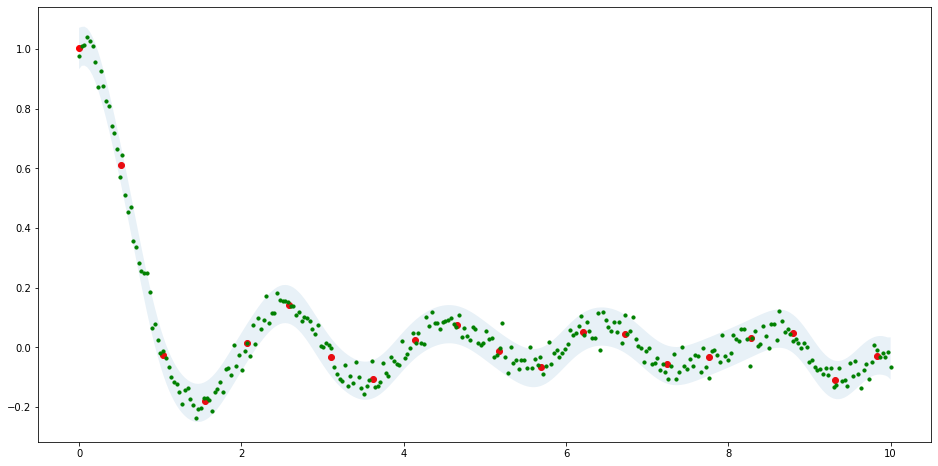

In [10]:
x, y, t, sigmas = dim1_make_data(func=np.sinc, start=0., end=15., nums=30, sigma_start=0.001, sigma_end=0.1)
gpr = GPR(0.001, k_func, 1, 10, 1, 1, expand=True) # Gaussian Process Regression
gpr.fit(x[:20], t[:20])
print(x.shape, t.shape)


plt.figure(figsize=(16,8))
plt.scatter(x[:20], t[:20], c='red')

test_x = np.linspace(0., 10., 300)
mus, covs = gpr.test(test_x)
# 주어진 covs에 대해 sampling 한다면,
samples = []
for mu, cov in zip(mus,covs) :
    samples.append(mu + np.sqrt(cov) * np.random.normal(0, 1, 1))


uncertainty = 1.96 * np.sqrt(np.array(covs)).reshape(-1)

plt.fill_between(test_x, np.array(mus).reshape(-1) + uncertainty, np.array(mus).reshape(-1) - uncertainty, alpha=0.1)
plt.scatter(test_x, samples, s=10, c='green')
plt.show()

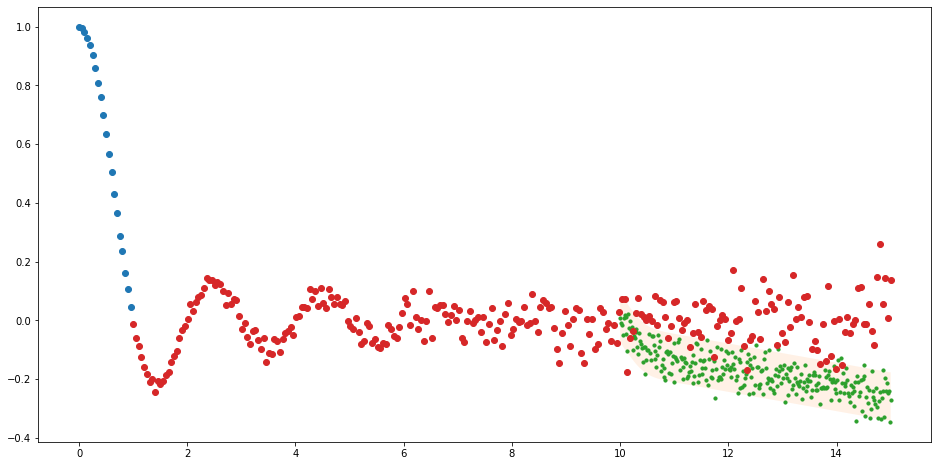

In [6]:
plt.figure(figsize=(16,8))
plt.scatter(x[:20], t[:20])

test_x = np.linspace(10., 15., 300)

mus, covs = gpr.test(test_x)



# 주어진 covs에 대해 sampling 한다면,

samples = []

for mu, cov in zip(mus,covs) :
    samples.append(mu + np.sqrt(cov) * np.random.normal(0, 1, 1))


uncertainty = 1.96 * np.sqrt(np.array(covs)).reshape(-1)

plt.fill_between(test_x, np.array(mus).reshape(-1) + uncertainty, np.array(mus).reshape(-1) - uncertainty, alpha=0.1)
plt.scatter(test_x, samples, s=10)
plt.scatter(x[20:], t[20:])

plt.show()